# Synthetic neural benchmarking

- this notebook will demo how to use CEBRA, piVAE, tSNE and UMAP on synthetic datasets.

- COLAB, Mac pre-M1, *Windows, and Ubuntu users can skip to cell 2.
- *This has not been tested on Windows

In [ ]:
#Attention: M1 chip users ONLY:
# TF is a dependency of piVAE, which is used in this demo.
# It requires a few extra steps that are addressed in this cell; in short, please run this once.
# See also: https://developer.apple.com/metal/tensorflow-plugin/ if any issues.

!pip uninstall -y tensorflow-deps tensorflow-macos tensorflow-metal keras

!conda install pytorch torchvision torchaudio -c pytorch
!pip install --upgrade --force-reinstall scikit-learn

!conda install -c apple -y tensorflow-deps==2.5.0 --force-reinstall
!python -m pip install tensorflow-macos
!python -m pip install tensorflow-metal

- Install note: be sure you have demo dependencies installed to use this notebook:

In [1]:
!pip install --pre 'cebra[datasets,demos]'

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
#import CEBRA:
import cebra.datasets
from cebra import CEBRA
from cebra.datasets import get_datapath

In [ ]:
# ONLY for using for t-sne, umap, and piVAE:
!pip install openTSNE
!pip install umap-learn
!git clone --depth 1 --filter=blob:none --sparse https://github.com/AdaptiveMotorControlLab/CEBRA.git && cd CEBRA && git sparse-checkout set third_party
!pip install tensorflow keras

In [4]:
#import other packages:
import matplotlib.pyplot as plt
import numpy as np
import torch
import joblib as jl
import sklearn.linear_model
import openTSNE
import umap
import keras

In [ ]:
#import piVAE:
import os
import sys
sys.path.insert(0, '/content/CEBRA/third_party')

# import
import pivae.pivae_code.pi_vae as pivae
from tensorflow.keras.callbacks import ModelCheckpoint

### Let's load the data:

- The data will be automatically downloaded into a `/data` folder.

In [6]:
dataset = cebra.datasets.init("continuous-label-poisson")

100%|██████████| 30.1M/30.1M [00:02<00:00, 14.2MB/s]

Download complete. Dataset saved in 'data/synthetic/continuous_label_poisson.jl'


(-3.411717481214122, 9.427972850408525, -4.042572592877058, 4.03572573445655)

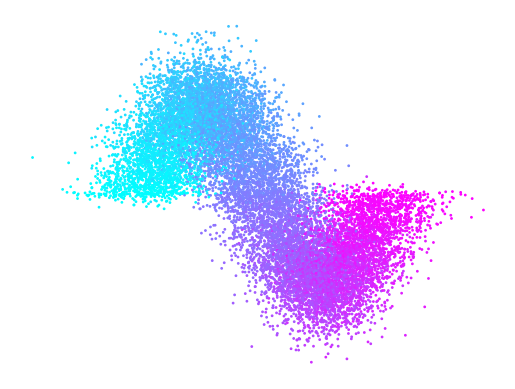

In [7]:
data = dataset.data
plt.scatter(data['z'][:, 0], data['z'][:, 1], c=data['u'], s=1, cmap='cool')
plt.axis('off')

### Define the reconstruction score we use for all methods:

In [8]:
def reconstruction_score(x, y):

    def _linear_fitting(x, y):
        lin_model = sklearn.linear_model.LinearRegression()
        lin_model.fit(x, y)
        return lin_model.score(x, y), lin_model.predict(x)

    return _linear_fitting(x, y)

# CEBRA

- Define & fit a 🦓 <font color='blue'>C</font><font color='MediumSlateBlue'>E</font><font color='BlueViolet'>B</font><font color='MediumVioletRed'>R</font><font color='red'>A</font>  model:
- For a quick CPU run-time demo, you can drop `max_iterations` to 500; otherwise set to 10,000.

In [9]:
max_iterations = 5000

In [10]:
cebra_model = CEBRA(
    model_architecture="offset1-model-mse",
    batch_size=512,
    learning_rate=1e-4,
    max_iterations=max_iterations,
    delta=0.1,
    conditional='delta',
    output_dimension=2,
    distance='euclidean',
    device="cuda_if_available",
    verbose=True,
)

In [11]:
cebra_model.fit(data['x'][:12000], data['u'][:12000])

pos:  0.6551 neg:  4.5135 total:  5.1686 temperature:  1.0000: 100%|██████████| 5000/5000 [16:31<00:00,  5.04it/s]


CEBRA(batch_size=512, conditional='delta', delta=0.1, distance='euclidean',
      learning_rate=0.0001, max_iterations=5000,
      model_architecture='offset1-model-mse', output_dimension=2, verbose=True)

linear reconstruction score: 0.9155677466979806


(-0.7319542288780212,
 8.35180081129074,
 -2.9202826380729676,
 2.9944043517112733)

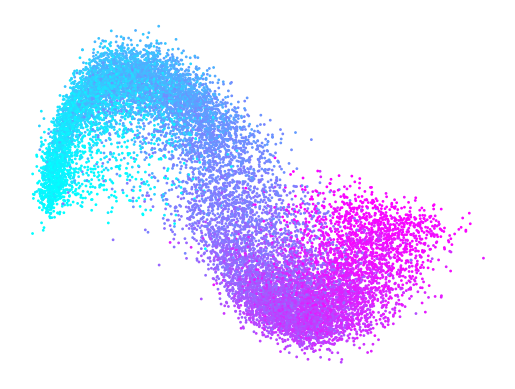

In [12]:
cebra_output = cebra_model.transform(data['x'])
cebra_score, transformed_cebra_z = reconstruction_score(cebra_output,
                                                        data['z'][:, :2])
print(f"linear reconstruction score: {cebra_score}")
plt.scatter(transformed_cebra_z[:, 0],
            transformed_cebra_z[:, 1],
            c=data['u'],
            s=1,
            cmap='cool')
plt.axis('off')

# t-SNE

In [13]:
tsne_model = openTSNE.TSNE(perplexity=84,
                           n_components=2,
                           initialization='pca',
                           random_state=None,
                           metric='euclidean')

In [14]:
tsne_model.fit(data['x'])
tsne_output = tsne_model.fit(data['x'])

linear reconstruction score: 0.788776430987681


(-0.5648915170388875,
 7.0257705428562085,
 -2.726191011070682,
 2.5588439549227457)

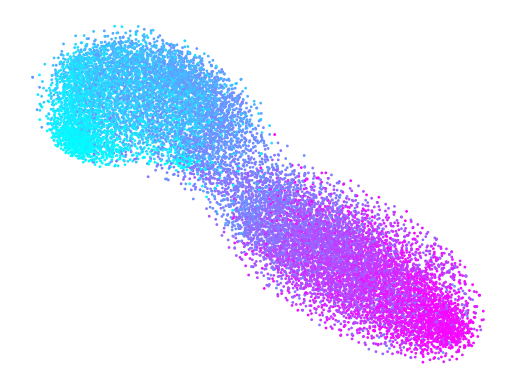

In [15]:
tsne_score, transformed_tsne_z = reconstruction_score(tsne_output,
                                                      data['z'][:, :2])
print(f"linear reconstruction score: {tsne_score}")
plt.scatter(transformed_tsne_z[:, 0],
            transformed_tsne_z[:, 1],
            c=data['u'],
            s=1,
            cmap='cool')
plt.axis('off')

# UMAP

In [16]:
umap_model = umap.UMAP(n_neighbors=68,
                       min_dist=0.2475,
                       n_components=2,
                       random_state=None,
                       metric='euclidean')
umap_output = umap_model.fit_transform(data['x'])

linear reconstruction score: 0.8302637230854306


(-0.45553902685642245,
 6.961537101864815,
 -2.585074985027313,
 2.8202560782432555)

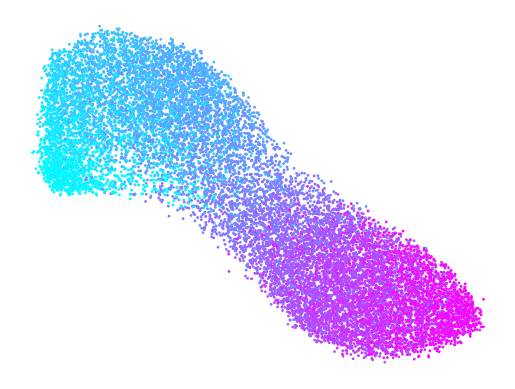

In [17]:
umap_score, transformed_umap_z = reconstruction_score(umap_output,
                                                      data['z'][:, :2])
print(f"linear reconstruction score: {umap_score}")
plt.scatter(transformed_umap_z[:, 0],
            transformed_umap_z[:, 1],
            c=data['u'],
            s=1,
            cmap='cool')
plt.axis('off')

# piVAE

The dataset parsing, model configuration and training are all adapted from https://github.com/zhd96/pi-vae/blob/main/examples/pi-vae_simulated_data_continuous_label.ipynb
- piVAE has a long run time. We store checkpoints.

In [ ]:
u_true = data['u']
z_true = data['z']
x_true = data['x']
x_all = x_true.reshape(50, 300, -1)
u_all = u_true.reshape(50, 300, -1)

x_train = x_all[:40]
u_train = u_all[:40]
x_valid = x_all[40:]
u_valid = u_all[40:]
print(f'Train set has {len(x_train)} samples')

In [ ]:
def custom_data_generator(x_train, u_train):
    while True:
        for i in range(len(x_train)):
            yield [x_train[i], u_train[i]], x_train[i]  # or appropriate target


In [ ]:
vae = pivae.vae_mdl(dim_x=x_all[0].shape[-1],
                    dim_z=2,
                    dim_u=u_all[0].shape[-1],
                    gen_nodes=60,
                    n_blk=2,
                    mdl='poisson',
                    disc=False,
                    learning_rate=5e-4)

In [ ]:
model_chk_path = 'synthetic_pivae.h5'

mcp = ModelCheckpoint(model_chk_path,
                      monitor="val_loss",
                      save_best_only=True,
                      save_weights_only=True)

s_n = vae.fit(pivae.custom_data_generator(x_train, u_train),
                        steps_per_epoch=len(x_train),
                        epochs=100,
                        verbose=0,
                        validation_data=pivae.custom_data_generator(
                            x_valid, u_valid),
                        validation_steps=len(x_valid),
                        callbacks=[mcp])

In [ ]:
vae.load_weights(model_chk_path)
outputs = vae.predict_generator(pivae.custom_data_generator(x_all, u_all),
                                steps=len(x_all))
#post_mean, post_log_var, z_sample,fire_rate, lam_mean, lam_log_var, z_mean, z_log_var
z_post = outputs[0]

In [ ]:
pivae_score, transformed_pivae_z = reconstruction_score(z_post,
                                                        data['z'][:, :2])
print(f"linear reconstruction score: {pivae_score}")
plt.scatter(transformed_pivae_z[:, 0],
            transformed_pivae_z[:, 1],
            c=data['u'],
            s=1,
            cmap='cool')
plt.axis('off')